# 基于深度学习的文本分类方法

## 主要内容    
* 前提介绍   
* 深度学习简介
* RNN, LSTM原理介绍
* pytorch介绍   
* torchtext、文本分类案例介绍

## 0. 前提介绍   

（今天的这个培训主要是结合之前我做的一个“行业偏离度”模型进行的，由于这个模型在业务逻辑上很简单，就是利用征信公司名称预测征信行业, 并与实际表填行业相比较，没有太多值得介绍的，所以本次培训以介绍建模技术为主要内容，这个模型的建设主要使用了“基于深度学习的文本分类”，后续我会介绍相关的理论与实践方法，由于信息安全的原因，介绍实践的过程会利用公开数据源进行）

## 1. 深度学习简介

### 1.1 深度神经网络结构简介

<img src="imgs/network_example.png" align="left"/>

<img src="imgs/simple_perceptron.png" align="left"/>

一个基础的神经网络主要由输入层、隐藏层以及输出层组成(如图1所示)，每一个黄色圆点叫做一个神经元，每两个神经元由一系列线性&非线性变换链接   

### 1.2 为什么深度学习是有效的？

神经元之间的非线性变换使模型具有表示复杂非线性关系的能力，而这正是建模过程中需要的(因为，机器学习就是学习数据与目标之间的某种复杂函数关系)

#### Demo演示(对深度神经网络非线性的一个直观展示)

https://cs.stanford.edu/people/karpathy/convnetjs//demo/classify2d.html

## 2. RNN, LSTM原理简介

下面我们来介绍一下适用于序列类（句子/文章、语音等）学习的网络RNN    

当我们阅读文章时，对当前词句的理解是基于前文进行的，所以我们的阅读、思考过程具有“持久性”，但传统的神经网络结构却无法表示这一点，`RNN(Recurrent neural network)`的提出解决了这一问题，这种网络结构中含有循环，因此可以允许信息“持久”保存

### 2.1 RNN的计算图&展开后的计算图

<img src="imgs/p1.png" align="left"/>

<img src="imgs/p2.png" align="left"/>

### 2.2 原版RNN存在长期依赖问题

理论中考虑了信息之间的相互依赖，并不代表实际使用中就能充分的利用这种依赖，实际上，原版的RNN难以保留长期依赖相关的信息，比如,如果利用RNN构建一个文本预测模型，那么不同长度的文本其实会有不同的表现

天空中有*云*    
* 短期依赖, RNN可以正常识别

<img src="imgs/p3.png" align="left"/>

我在法国长大, ............... 我可以说流利的*法语*    
* 长期依赖, RNN难以识别(梯度长期传播会逐渐消失, 逻辑上类似 0.1^100 -> 0)

<img src="imgs/p4.png" align="left"/>

### 2.3 LSTM: 同时考虑长、短期记忆的RNN

<img src="imgs/p5.png" align="left"/>

<img src="imgs/p6.png" align="left"/>

#### 2.3.1 通过增加线性运算部分，解决长期依赖问题    
* C：cell state

<img src="imgs/p7.png" align="left"/>

#### 2.3.2 控制cell state信息的保留部分   
* f: forget gate

<img src="imgs/p8.png" align="left"/>

#### 2.3.3 控制cell state信息的新增部分    
* i: input gate

<img src="imgs/p9.png" align="left"/>

#### 2.3.4 生成新的cell state信息

<img src="imgs/p10.png" align="left"/>

#### 2.3.5 以非线性方式生成h     
* 与原有RNN结构类似, 不过是基于更新后的cell state

<img src="imgs/p11.png" align="left"/>

## 3. pytorch介绍

### 3.1 pytorch简介    
* pytorch是什么: PyTorch是一个开源的Python机器学习库，基于Torch，最初由Facebook开发
* 为什么使用pytorch: 动态计算图便于构建网络, 便于调试; 无需使用新增语法构建网络, 使用python标准语法即可

<img src="imgs/pytorch_joke.png" align="left"/>

### 3.2 pytorch主要部分：  
* tensor: 张量      
    * 存储数据的基本变量(可以认为是多维数组)       
           
* autograd: 自动微分系统
    * 深度学习的算法本质上是通过反向传播求导数，而autograd模块则实现了此功能。在Tensor上的所有操作，autograd都能为它们自动提供微分
                  
* nn: 常用神经网络的封装与函数
    * Autograd实现了反向传播功能，但是直接用来写深度学习的代码在很多情况下还是稍显复杂，torch.nn是专门为神经网络设计的模块化接口。nn构建于Autograd之上，可用来定义和运行神经网络。
    * nn.Module是nn中最重要的类，可把它看成是一个网络的封装，包含网络各层定义以及forward方法，利用nn.Module搭建网络,仅需实现初始化以及前向传播,而无需实现反向传播     
                 
* 其他: 优化器(torch.optim), 其它函数(nn.Functional)

(下面简单介绍一下tensor和nn的操作方式)

#### 3.2.1 Tensor例子

In [1]:
import numpy as np
import pandas as pd

/home/azurite/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
import torch as t # 注意包名是torch, 不是pytorch

几个Tensor操作的例子

In [3]:
x = t.Tensor([[1,2],[3,4]])
x

tensor([[1., 2.],
        [3., 4.]])

In [4]:
# 使用[0,1]均匀分布随机初始化二维数组
x = t.rand(5, 3)  
x

tensor([[0.0010, 0.2716, 0.0785],
        [0.1225, 0.1551, 0.7609],
        [0.0991, 0.8552, 0.1813],
        [0.4214, 0.5452, 0.7405],
        [0.8041, 0.1878, 0.9650]])

In [5]:
a = t.ones(5) # 新建一个全1的Tensor
a

tensor([1., 1., 1., 1., 1.])

In [6]:
# Tensor和 Numpy array可以相互转换
b = a.numpy() # Tensor -> Numpy
b

array([1., 1., 1., 1., 1.], dtype=float32)

In [7]:
a = np.ones(5)
b = t.from_numpy(a) # Numpy->Tensor
print(a)
print(b) 

[1. 1. 1. 1. 1.]
tensor([1., 1., 1., 1., 1.], dtype=torch.float64)


#### 3.2.2 nn.Module例子

* 基于nn.Module定义网络时, 需要继承`nn.Module`, 并仅需实现其初始化方法(`__init__`, 告诉框架结构如何, 哪些是可训练参数), 以及前向传播方法(`forward`), 而无需实现反向传播方法(框架会利用`autograd`自动生成反向传播方法)       
* 如果某一层(如ReLU)不具有可学习的参数，则既可以放在构造函数中，也可以不放，但建议不放在其中，而在forward中使用`nn.functional`代替。

多层感知机的网络结构如图4-1所示，它由两个全连接层组成，采用$sigmoid$函数作为激活函数，图中没有画出。
![多层感知机](imgs/multi_perceptron.png)

这是一个基础的前馈(feed-forward)网络: 接收输入，经过层层传递运算，得到输出。 

In [8]:
import torch.nn as nn

In [9]:
class Perceptron(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        nn.Module.__init__(self)
        # 此处使用了nn中预先定义好的线性层的结构, 第一个参数是输入维度,第二个是输出维度
        self.layer1 = nn.Linear(in_features, hidden_features) 
        self.layer2 = nn.Linear(hidden_features, out_features)
    def forward(self,x):
        x = self.layer1(x)
        x = t.sigmoid(x)
        return self.layer2(x)

In [10]:
perceptron = Perceptron(3, 4, 1) #生成如上图的3个input, 4个隐藏单元, 1个output的网络结构的实例
for name, param in perceptron.named_parameters():
    print(name, param.size())

layer1.weight torch.Size([4, 3])
layer1.bias torch.Size([4])
layer2.weight torch.Size([1, 4])
layer2.bias torch.Size([1])


#### 3.2.3 一个简单的全流程训练例子   
基于pytorch的模型的训练流程，主要由以下几部分组成    
* 处理数据
* 构建网络    
* 确定损失函数和优化方法   
* 开始进行优化

In [11]:
import torch as t
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [12]:
import torch as t
%matplotlib inline
from matplotlib import pyplot as plt
from IPython import display

处理数据(生成dummy数据)    

In [13]:
def generate_dataset(size=100):
    # 公式: y = 3x + 4 + ε
    inputs = []
    outputs = []
    for ix in range(size):
        random_number = np.random.randint(100) / 100
        inputs.append([random_number])
        outputs.append([3 * random_number + 4 + np.random.normal() / 10])
    return inputs, outputs

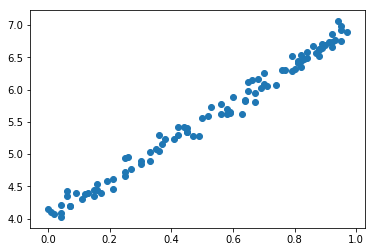

In [14]:
# 来看看产生的x-y分布
test_x, test_y = generate_dataset()
plt.scatter(test_x, test_y)

构建网络

In [15]:
class LR(nn.Module):
    def __init__(self):
        super(LR, self).__init__()
        self.fc = nn.Linear(1, 1)
    
    def forward(self, x):
        x = self.fc(x)
        return x
    
model = LR()

确定损失函数和优化方法

In [16]:
# define critereon - loss function
critereon = nn.MSELoss()
# define optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.01)

开始进行优化

In [17]:
inputs, labels = generate_dataset(100)
nb_epochs = 30
for epoch in range(nb_epochs):
    epoch_loss = 0
    for ix, x in enumerate(inputs):
        # here x is the input. i.e. the input value of x
        # and y_train[ix] is the output. i.e. y = f(x) = 3x + 4
        y_pred = model(t.Tensor(x))
        
        loss = critereon(y_pred, t.Tensor(labels[ix]))
        
        epoch_loss = loss.data.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 5 == 4:
        print("Epoch {} : Loss {}".format(epoch, epoch_loss))

Epoch 4 : Loss 1.2313394108787179e-05
Epoch 9 : Loss 0.001408836804330349
Epoch 14 : Loss 0.0030088736675679684
Epoch 19 : Loss 0.004053980112075806
Epoch 24 : Loss 0.00464647589251399
Epoch 29 : Loss 0.004963480867445469


简要测试

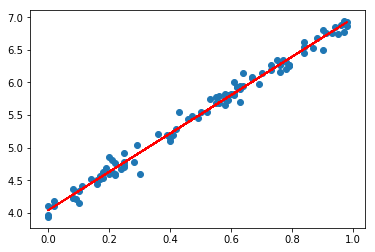

In [18]:
#x_test, y_test = get_fake_data(batch_size=40)
label_pred = model(t.Tensor(inputs))
plt.scatter(inputs, labels) # predicted

plt.plot(inputs, label_pred.detach().numpy(), 'r')
plt.show()

## 4. torchtext、文本分类案例介绍    
基于上述的理论与实践知识，我们可以开始建设实际的文本分类模型了，我们会基于`Toxic Comment Classification`这个例子进行介绍    
由于实际工程任务中，预处理相关操作较为繁琐，在这里我也会同步介绍一个用于文本预处理的torchtext包

`Toxic Comment Classification`： “有毒”评论分类   
数据选取了Wikipedia’s talk page edits下的评论，分别被标注了toxic、severe_toxic、obscene、threat、insult以及identity_hate这6类标签，目的是建立模型以判断某条评论是否出现以上行为

<img src="imgs/torchtext_routine.png" align="left"/>

### 4.1 查看数据基本情况

In [19]:
!ls data

test.csv  train.csv  valid.csv


In [20]:
tp = pd.read_csv("data/train.csv").head(2)

In [21]:
tp

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0


In [22]:
tp['comment_text'].iloc[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

### 4.2 声明 Fields

如何对文本数据进行预处理并转换为数字，是利用Field实现的

In [23]:
import torch
from torchtext.data import Field

我们想把comment_text转化为小写，并按空格进行token化，所以如下选择Field参数

In [24]:
tokenize = lambda x: x.split()
TEXT = Field(sequential=True, tokenize=tokenize, lower=True)

由于此数据集中标签已进行基础处理，所以对标签的处理就更为简单

In [25]:
LABEL = Field(sequential=False, use_vocab=False)

### 4.3 生成数据集

由于数据源是csv格式的，我们使用TabularDataset读取数据 (目前TabularDataset可以处理csv, tsv, 以及json文件)

In [26]:
from torchtext.data import TabularDataset

对于训练、验证数据，我们需要处理标签，传入参数的顺序必须与数据集中的顺序一直（不需要的数据可以传个None）

In [27]:
%%time
tv_datafields = [("id", None), 
                 ("comment_text", TEXT), ("toxic", LABEL),
                 ("severe_toxic", LABEL), ("threat", LABEL),
                 ("obscene", LABEL), ("insult", LABEL),
                 ("identity_hate", LABEL)]

trn, vld = TabularDataset.splits(
        path="data", # 数据都在data文件夹下
        train='train.csv', validation="valid.csv",
        format='csv',
        skip_header=True,
        fields=tv_datafields)

CPU times: user 3.23 ms, sys: 0 ns, total: 3.23 ms
Wall time: 5.1 ms


测试集中没有任何的标签

In [28]:
%%time
tst_datafields = [("id", None), 
                 ("comment_text", TEXT)
]

tst = TabularDataset(
        path="data/test.csv", # the file path
        format='csv',
        skip_header=True,
        fields=tst_datafields)

CPU times: user 1.83 ms, sys: 0 ns, total: 1.83 ms
Wall time: 9.16 ms


embedding(词嵌入，用一个低维向量表示词) 之类的后续处理，需要先将文本转化为数字，因此我们需要基于文本构建词库，构建方法如下

In [29]:
%%time
TEXT.build_vocab(trn)

CPU times: user 2.08 ms, sys: 0 ns, total: 2.08 ms
Wall time: 2.08 ms


词库如下， vocab.freqs是一个collections.Counter对象，所以我们可以看一下最常出现的几个词

In [30]:
TEXT.vocab.freqs.most_common(10)

[('the', 78),
 ('to', 41),
 ('you', 33),
 ('of', 30),
 ('and', 26),
 ('a', 26),
 ('is', 24),
 ('that', 22),
 ('i', 20),
 ('if', 19)]

我们稍微看一下数据集被转换成什么样子，数据集可以像list一样使用索引

In [31]:
trn[0].comment_text[:3]

['explanation', 'why', 'the']

### 4.4 创建迭代器

In [32]:
from torchtext.data import Iterator, BucketIterator

对train和valid数据集，我们使用一种特殊的iterator，叫**BucketIterator**    
当我们使用神经网络进行训练时，每一个batch的长度应该是一样的，长度不足的会补0，过长的会切断   
e.g.
\[ 
\[3, 15, 2, 7\],
\[4, 1\], 
\[5, 5, 6, 8, 1\] 
\] -> \[ 
\[3, 15, 2, 7, **0**\],
\[4, 1, **0**, **0**, **0**\], 
\[5, 5, 6, 8, 1\] 
\]    
如果数据长度相差太多，处理过程就会比较费时    
BucketIterator会将相似长度的数据放到一起处理，降低耗时

In [33]:
train_iter, val_iter = BucketIterator.splits(
        (trn, vld), # we pass in the datasets we want the iterator to draw data from
        batch_sizes=(64, 64),
        device=-1, # if you want to use the GPU, specify the GPU number here
        sort_key=lambda x: len(x.comment_text), # the BucketIterator needs to be told what function it should use to group the data.
        sort_within_batch=False,
        repeat=False # we pass repeat=False because we want to wrap this Iterator layer.
)

The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.


test部分不需要重排序，所以使用标准的Iterator

In [34]:
test_iter = Iterator(tst, batch_size=64, device=-1, sort=False, sort_within_batch=False, repeat=False)

The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.


### 4.5 封装迭代器

为了便于使用，我们将把batch转换为形式为（x，y）的元组，其中x是自变量（模型的输入），y是因变量（标签数据）

In [35]:
class BatchWrapper:
    def __init__(self, dl, x_var, y_vars):
        self.dl, self.x_var, self.y_vars = dl, x_var, y_vars # we pass in the list of attributes for x and y
    
    def __iter__(self):
        for batch in self.dl:
            x = getattr(batch, self.x_var) # we assume only one input in this wrapper
            
            if self.y_vars is not None: # we will concatenate y into a single tensor
                y = torch.cat([getattr(batch, feat).unsqueeze(1) for feat in self.y_vars], dim=1).float()
            else:
                y = torch.zeros((1))

            yield (x, y)
    
    def __len__(self):
        return len(self.dl)

用上面这个类来封装BucketIterator

In [36]:
train_dl = BatchWrapper(train_iter, "comment_text", ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"])
valid_dl = BatchWrapper(val_iter, "comment_text", ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"])
test_dl = BatchWrapper(test_iter, "comment_text", None)

下面就是每一组我们实际用来训练的数据、标签在经过上述预处理后的结果

In [37]:
next(train_dl.__iter__())

(tensor([[ 15,  55,  15,  ...,  63, 375,  15],
         [ 46, 531,   2,  ...,   4,  27, 144],
         [ 10,   3, 645,  ..., 664, 526,   3],
         ...,
         [  1,   1,   1,  ...,   1,   1,   1],
         [  1,   1,   1,  ...,   1,   1,   1],
         [  1,   1,   1,  ...,   1,   1,   1]]),
 tensor([[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [1., 1., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
  

### 4.6 建立并训练文本分类器

此处利用我们上面提到的LSTM建立模型

In [38]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

nn.LSTM的使用方法

In [53]:
#seq_len: timestep的数量        
#batch_size: batch的大小       
#input_size: 有多少个变量       
#hidden_size: 隐藏单元个数      
#number_layers: 层数      

    
#input = t.rand(seq_len, batch_size, input_size)       
#lstm = nn.LSTM(input_size, hidden_size, number_layers)
#h0 = t.randn(number_layers, batch_size, hidden_size)
#c0 = t.randn(number_layers, batch_size, hidden_size)
#out, hn = lstm(input, (h0, c0))

In [39]:
class SimpleBiLSTMBaseline(nn.Module):
    def __init__(self, hidden_dim, emb_dim=300, recurrent_dropout=0.1, num_linear=1):
        super().__init__() # don't forget to call this!
        self.embedding = nn.Embedding(len(TEXT.vocab), emb_dim)
        self.encoder = nn.LSTM(emb_dim, hidden_dim, num_layers=1, dropout=recurrent_dropout)
        self.linear_layers = []
        for _ in range(num_linear - 1):
            self.linear_layers.append(nn.Linear(hidden_dim, hidden_dim))
        # 含可优化参数的层，需要使用nn.ModuleList, 这样其中可优化参数才能存到构造函数中的正确位置
        self.linear_layers = nn.ModuleList(self.linear_layers)
        self.predictor = nn.Linear(hidden_dim, 6)
    
    def forward(self, seq):
        hdn, _ = self.encoder(self.embedding(seq))
        feature = hdn[-1, :, :]
        for layer in self.linear_layers:
            feature = layer(feature)
        preds = self.predictor(feature)
        return preds

In [40]:
em_sz = 100
nh = 500
nl = 3
model = SimpleBiLSTMBaseline(nh, emb_dim=em_sz); model

/home/azurite/anaconda3/lib/python3.6/site-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


SimpleBiLSTMBaseline(
  (embedding): Embedding(784, 100)
  (encoder): LSTM(100, 500, dropout=0.1)
  (linear_layers): ModuleList()
  (predictor): Linear(in_features=500, out_features=6, bias=True)
)

If you're using a GPU, remember to call model.cuda() to move your model to the GPU.

In [41]:
#model.cuda()

### 4.7 开始训练

In [42]:
import tqdm

In [43]:
opt = optim.Adam(model.parameters(), lr=1e-2)
loss_func = nn.BCEWithLogitsLoss()

In [44]:
epochs = 20

In [46]:
%%time
for epoch in range(1, epochs + 1):
    running_loss = 0.0
    running_corrects = 0
    model.train() # turn on training mode
    for x, y in tqdm.tqdm(train_dl): # thanks to our wrapper, we can intuitively iterate over our data!
        opt.zero_grad()
        #x = x.cuda()
        #y = y.cuda()
        preds = model(x)
        loss = loss_func(preds, y)
        loss.backward()
        opt.step()
        
        running_loss += loss.data.item() * x.size(0)
        
    epoch_loss = running_loss / len(trn)
    
    # calculate the validation loss for this epoch
    val_loss = 0.0
    model.eval() # turn on evaluation mode
    for x, y in valid_dl:
        #x = x.cuda()
        #y = y.cuda()
        preds = model(x)
        loss = loss_func(preds, y)
        val_loss += loss.data.item() * x.size(0)

    val_loss /= len(vld)
    print('Epoch: {}, Training Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch, epoch_loss, val_loss))

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1, Training Loss: 3.6392, Validation Loss: 1.9101


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 2, Training Loss: 3.1103, Validation Loss: 2.0560


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 3, Training Loss: 3.4557, Validation Loss: 1.8737


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 4, Training Loss: 2.9264, Validation Loss: 1.9535


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 5, Training Loss: 2.9963, Validation Loss: 2.0557


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 6, Training Loss: 3.0620, Validation Loss: 2.1251


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 7, Training Loss: 3.0596, Validation Loss: 2.1504


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 8, Training Loss: 3.0028, Validation Loss: 2.1407


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 9, Training Loss: 2.9146, Validation Loss: 2.1359


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 10, Training Loss: 2.8748, Validation Loss: 2.1643


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 11, Training Loss: 2.9285, Validation Loss: 2.1937


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 12, Training Loss: 2.9692, Validation Loss: 2.1958


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 13, Training Loss: 2.9182, Validation Loss: 2.2014


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 14, Training Loss: 2.8668, Validation Loss: 2.2309


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 15, Training Loss: 2.8795, Validation Loss: 2.2640


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 16, Training Loss: 2.9103, Validation Loss: 2.2802


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 17, Training Loss: 2.9169, Validation Loss: 2.2797


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 18, Training Loss: 2.8978, Validation Loss: 2.2741


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 19, Training Loss: 2.8713, Validation Loss: 2.2765


100%|██████████| 1/1 [00:04<00:00,  4.38s/it]

Epoch: 20, Training Loss: 2.8613, Validation Loss: 2.2910
CPU times: user 8min 52s, sys: 14.5 s, total: 9min 6s
Wall time: 2min 11s


### 4.8 预测

In [49]:
test_preds = []
for x, y in tqdm.tqdm(test_dl):
    #x = x.cuda()
    #y = y.cuda()
    preds = model(x)
    # if you're data is on the GPU, you need to move the data back to the cpu
    #preds = preds.data.cpu().numpy()
    preds = preds.data.numpy()
    # the actual outputs of the model are logits, so we need to pass these values to the sigmoid function
    preds = 1 / (1 + np.exp(-preds))
    test_preds.append(preds)
test_preds = np.hstack(test_preds)

100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


In [50]:
df = pd.read_csv("data/test.csv")
for i, col in enumerate(["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]):
    df[col] = test_preds[:, i]

# if you want to write the submission file to disk, uncomment and run the below code
# df.drop("comment_text", axis=1).to_csv("submission.csv", index=False)

In [51]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,0.15087,0.044557,1.370166e-07,0.050182,0.03885,1.170060e-07
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,0.15087,0.044557,1.370166e-07,0.050182,0.03885,1.170060e-07
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0.15087,0.044557,1.370166e-07,0.050182,0.03885,1.170060e-07
3,00017563c3f7919a,":If you have a look back at the source, the in...",0.15087,0.044557,1.370166e-07,0.050182,0.03885,1.170060e-07
4,00017695ad8997eb,I don't anonymously edit articles at all.,0.15087,0.044557,1.370166e-07,0.050182,0.03885,1.170060e-07


Reference:   
  * http://colah.github.io/posts/2014-03-NN-Manifolds-Topology/
  * http://colah.github.io/posts/2015-08-Understanding-LSTMs/   
  * https://github.com/chenyuntc/pytorch-book   
  * https://medium.com/@ally_20818/pytorch-101-linear-regression-with-pytorch-d2d22291c37d 
  * `Toxic Comment Classification`: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge        
  * https://zhuanlan.zhihu.com/p/37223078    
  * https://github.com/keitakurita/practical-torchtext